# Lab 2: ES

## Task
Write agents able to play [*Nim*](https://en.wikipedia.org/wiki/Nim), with an arbitrary number of rows and an upper bound $k$ on the number of objects that can be removed in a turn (a.k.a., *subtraction game*).

The goal of the game is to **avoid** taking the last object.

* Task2.1: An agent using fixed rules based on *nim-sum* (i.e., an *expert system*)
* Task2.2: An agent using evolved rules using ES


## Instructions

* Create the directory `lab2` inside your personal course repository for the course 
* Put a `README.md` and your solution (all the files, code and auxiliary data if needed)

## Notes

* Working in group is not only allowed, but recommended (see: [Ubuntu](https://en.wikipedia.org/wiki/Ubuntu_philosophy) and [Cooperative Learning](https://files.eric.ed.gov/fulltext/EJ1096789.pdf)). Collaborations must be explicitly declared in the `README.md`.
* [Yanking](https://www.emacswiki.org/emacs/KillingAndYanking) from the internet is allowed, but sources must be explicitly declared in the `README.md`.



In [83]:
import logging
from pprint import pprint, pformat
from collections import namedtuple
import random
from copy import deepcopy

from dataclasses import dataclass
from random import randint,choice
from copy import copy
import matplotlib.pyplot as plt


## The *Nim* and *Nimply* classes

In [84]:
Nimply = namedtuple("Nimply", "row, num_objects") #represents a move in the game


In [85]:
class Nim:
    def __init__(self, num_rows: int, k: int = None) -> None:
        #Each row initially contains an odd number of objects (1, 3, 5, etc.)
        #so if Nim(5) -> [1, 3, 5, 7, 9] which represent the nr of objects
        self._rows = [i * 2 + 1 for i in range(num_rows)]
        self._k = k

    def __bool__(self): #if false, the game is over
        return sum(self._rows) > 0

    def __str__(self): #  string representation of the Nim game state (# of objects in each row)
        return "<" + " ".join(str(_) for _ in self._rows) + ">"

    @property
    def rows(self) -> tuple: #Creates a property to access the rows of the Nim game.
        return tuple(self._rows) #The rows property returns a tuple containing the current state of all rows in the Nim game.

    def nimming(self, ply: Nimply) -> None: #Modifies the Nim game state based on the player's move.
        row, num_objects = ply #Represents a move in the game, containing the row index and the number of objects to remove.
        assert self._rows[row] >= num_objects #Checks if the number of objects to remove from the specified row is less than or equal to the number of objects in that row
        assert self._k is None or num_objects <= self._k #Checks if the number of objects to remove complies with the upper limit _k (if _k is not None)
        self._rows[row] -= num_objects #Updates the game state by subtracting the specified number of objects from the specified row.


## Sample (and silly) startegies 

In [86]:
def pure_random(state: Nim) -> Nimply:
    """A completely random move"""
    row = random.choice([r for r, c in enumerate(state.rows) if c > 0])
    num_objects = random.randint(1, state.rows[row])
    return Nimply(row, num_objects)


In [87]:
def gabriele(state: Nim) -> Nimply:
    """Pick always the maximum possible number of the lowest row"""
    possible_moves = [(r, o) for r, c in enumerate(state.rows) for o in range(1, c + 1)]
    return Nimply(*max(possible_moves, key=lambda m: (-m[0], m[1])))


In [88]:
def adaptive(state: Nim) -> Nimply:
    """A strategy that can adapt its parameters"""
    genome = {"love_small": 0.5}


In [89]:
import numpy as np

#In Nim, achieving a nim-sum of zero after your turn guarantees a winning strategy because it means you can always manipulate the game's state to force your opponent into positions where they cannot achieve a nim-sum of zero on their turn, thereby securing your victory.
def nim_sum(state: Nim) -> int:
    tmp = np.array([tuple(int(x) for x in f"{c:032b}") for c in state.rows])
    xor = tmp.sum(axis=0) % 2
    return int("".join(str(_) for _ in xor), base=2)


def analize(raw: Nim) -> dict: # Analyzes all possible moves and their resulting nim-sums for a given state.
    cooked = dict()
    cooked["possible_moves"] = dict()
    #Loops through all possible moves (combinations of rows and the number of objects to remove).
    for ply in (Nimply(r, o) for r, c in enumerate(raw.rows) for o in range(1, c + 1)):
        #For each move, it creates a copy of the current state, 
        # performs the move, and calculates the resulting nim-sum after that move.
        tmp = deepcopy(raw)
        tmp.nimming(ply)
        cooked["possible_moves"][ply] = nim_sum(tmp) #Stores these resulting nim-sums in the cooked dictionary with their respective moves.
    return cooked

#this makes player 0 win
#determines an optimal move based on the analysis of resulting nim-sums.
def optimal(state: Nim) -> Nimply:
    analysis = analize(state) #Calls the analize function to get the analysis of all possible moves and their nim-sums.
    logging.debug(f"analysis:\n{pformat(analysis)}") 
    #Collects moves with non-zero nim-sums into spicy_moves
    spicy_moves = [ply for ply, ns in analysis["possible_moves"].items() if ns != 0]
    #If there are no spicy_moves (all moves result in a nim-sum of zero), it considers all possible moves.
    if not spicy_moves:
        spicy_moves = list(analysis["possible_moves"].keys()) #Randomly selects a move from either spicy_moves or all possible moves if spicy_moves is empty.
    ply = random.choice(spicy_moves) #Returns the selected move (Nimply object) as the optimal move to play.
    return ply


## Oversimplified match

In [90]:
logging.getLogger().setLevel(logging.INFO)

strategy = (optimal, pure_random) #These functions represent the strategies that the players will use to make their moves during the game.

nim = Nim(5) #Initializes the Nim game with 5 rows 
logging.info(f"init : {nim}")
player = 0 #player 0 starts
while nim: # continues as long as the game state nim is not empty
    ply = strategy[player](nim) #Selects the strategy for the current player based on the value of player with the current state of nim
    #so,Player 0 uses the optimal strategy, while Player 1 uses the pure_random strategy
    logging.info(f"ply: player {player} plays {ply}")
    nim.nimming(ply) #Modifies the game state by applying the selected move (ply)
    logging.info(f"status: {nim}")
    player = 1 - player #Switches the player to the next turn (alternates between 0 and 1).
logging.info(f"status: Player {player} won!")


INFO:root:init : <1 3 5 7 9>
INFO:root:ply: player 0 plays Nimply(row=2, num_objects=2)
INFO:root:status: <1 3 3 7 9>
INFO:root:ply: player 1 plays Nimply(row=3, num_objects=7)
INFO:root:status: <1 3 3 0 9>
INFO:root:ply: player 0 plays Nimply(row=4, num_objects=9)
INFO:root:status: <1 3 3 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 3 2 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <1 2 2 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <1 2 1 0 0>
INFO:root:ply: player 0 plays Nimply(row=0, num_objects=1)
INFO:root:status: <0 2 1 0 0>
INFO:root:ply: player 1 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 1 1 0 0>
INFO:root:ply: player 0 plays Nimply(row=1, num_objects=1)
INFO:root:status: <0 0 1 0 0>
INFO:root:ply: player 1 plays Nimply(row=2, num_objects=1)
INFO:root:status: <0 0 0 0 0>
INFO:root:status: Player 0 won!


In [102]:

#these parameters need to be tuned
POPULATION_SIZE = 20 # Number of individuals in the population
OFFSPRING_SIZE = 10 #Number of offspring generated in each generation.
TOURNAMENT_SIZE = 3
MUTATION_PROBABILITY = 0.15 #: Probability of a mutation occurring during reproduction

UPPERBOUND_K = 3 # number of objects that can be taken from a row
NUM_ROWS = 5

# total number of moves possible in the game based on the number of rows
#It computes half the sum of odd numbers up to NUM_ROWS (e.g. for 5 rows: 1 + 3 + 5 = 9 moves)
#NUM_MOVES= total number of objects // number of players
TOT_OBJECTS = sum([i * 2 + 1 for i in range(NUM_ROWS)])
NUM_PLAYERS = 2
NUM_MOVES = TOT_OBJECTS // NUM_PLAYERS



In [103]:
def fitness(genotype):
    # Define the opponent strategies
    strategies = (pure_random, gabriele, optimal)
    
    # Initialize variables to track the score and number of wins
    total_score = 0
    num_wins = 0

    # Simulate multiple rounds against each opponent strategy
    for strategy in strategies:
        for _ in range(10):  # Play 10 rounds against each opponent strategy
            nim = Nim(5)  # Initialize a game of Nim
            current_strategy = genotype[:]  # Make a copy of the genotype
            
            # Initialize players and counters
            player = 0
            num_moves = 0
            
            while nim:
                if player == 0:  # Player 0's turn
                    if len(current_strategy) > 0:
                        ply = current_strategy.pop(0)  # Get move from genotype
                    else:
                        # If strategy list is exhausted, make a random  move
                        ply = (randint(0, NUM_ROWS-1), 1)
                    
                    # Check if the chosen move is valid
                    while nim._rows[ply[0]] < ply[1]:
                        ply = (randint(0, NUM_ROWS-1), 1)  # Choose a valid random move
                    
                    num_moves += 1  # Increment move count
                    
                else:  # Player 1's turn - Opponent strategy's move
                    ply = strategy(nim)  # Opponent strategy makes a move
                
                nim.nimming(ply)  # Apply the chosen move
                player = 1 - player  # Switch players
                
            if player == 0:  # Player 0 wins
                num_wins += 1  # Increment win count
            
            # Update total score based on the number of moves made in the game
            total_score += num_moves
            
    # Calculate the final fitness score based on wins and average number of moves
    fitness_score = (num_wins * 100) + (total_score / 30)  # 30 total rounds (3 strategies * 10 rounds)
    
    #Decreased the weight for the number of wins by multiplying the number of wins by 75 instead of 100, reducing its influence on the final score.
    #Increased the weight for the average moves per round by multiplying the average number of moves by 2 instead of 1, giving more weight to longer games.

    #fitness_score = (num_wins * 75) + (total_score / 30) * 2  # 30 total rounds (3 strategies * 10 rounds)



    return fitness_score

This adjustment aims to place more emphasis on the average number of moves played per round while slightly reducing the impact of the number of wins on the final fitness score. By tweaking these weights, it can encourage the evolution of strategies that not only win but also play longer games, potentially improving resilience and adaptability.

In [104]:
def alternative_fitness(genotype):
    # Define the opponent strategies
    strategies = (pure_random, gabriele, optimal)
    
    # Initialize variables to track the score and number of wins
    total_score = 0
    num_wins = 0

    # Simulate multiple rounds against each opponent strategy
    for strategy in strategies:
        for _ in range(10):  # Play 10 rounds against each opponent strategy
            nim = Nim(5)  # Initialize a game of Nim
            current_strategy = genotype[:]  # Make a copy of the genotype
            
            # Initialize players and counters
            player = 0
            num_moves = 0
            
            while nim:
                if player == 0:  # Player 0's turn
                    if len(current_strategy) > 0:
                        ply = current_strategy.pop(0)  # Get move from genotype
                    else:
                        # If strategy list is exhausted, make a random  move
                        ply = (randint(0, NUM_ROWS-1), 1)
                    
                    # Check if the chosen move is valid
                    while nim._rows[ply[0]] < ply[1]:
                        ply = (randint(0, NUM_ROWS-1), 1)  # Choose a valid random move
                    
                    num_moves += 1  # Increment move count
                    
                else:  # Player 1's turn - Opponent strategy's move
                    ply = strategy(nim)  # Opponent strategy makes a move
                
                nim.nimming(ply)  # Apply the chosen move
                player = 1 - player  # Switch players
                
            if player == 0:  # Player 0 wins
                num_wins += 1  # Increment win count
            
            # Update total score based on the number of moves made in the game
            total_score += num_moves
            
    # Calculate the final fitness score based on wins and average number of moves
    #fitness_score = (num_wins * 100) + (total_score / 30)  # 30 total rounds (3 strategies * 10 rounds)
    
    #Decreased the weight for the number of wins by multiplying the number of wins by 75 instead of 100, reducing its influence on the final score.
    #Increased the weight for the average moves per round by multiplying the average number of moves by 2 instead of 1, giving more weight to longer games.

    fitness_score = (num_wins * 75) + (total_score / 30) * 2  # 30 total rounds (3 strategies * 10 rounds)



    return fitness_score


In [105]:
@dataclass
class Individual:       #Each "individual" represents a candidate solution or strategy to play the game 
    fitness: int        # evaluation score of the individual strategy
    genotype: list[(int, int)] #list of (row, num_objects)

population = [
    Individual(        
        fitness=None,
        genotype=[],
    )
    for _ in range(POPULATION_SIZE)
]

# code below generates random moves for each individual in the population, stores these moves in their genotypes, and calculates the fitness value for each individual based on their generated genotype 
#the list comprehension creates a list of tuples where each tuple contains a random row index and a random number of objects to remove from that row, ensuring that the number of objects doesn't exceed the upper bound limit specified by UPPERBOUND_K
for individual in population:
    moves = [
        (
            randint(0, NUM_ROWS - 1), #generates a random row number
            min(randint(1, (row + 1) * 2), UPPERBOUND_K) # objects to be removed and to avoid  picking more objects than available in a row, it takes the minimum 
        )
        for _ in range(NUM_MOVES) #creates NUM_MOVES number of tuples(moves)
        for row in [randint(0, NUM_ROWS - 1)] #innermost, generates a random row number for the move
    ]
    individual.genotype.extend(moves) #appending the generated list of moves to it. Each move is represented as a tuple within the genotype list of the individual
    individual.fitness = alternative_fitness(individual.genotype)



In [106]:
def select_parent(pop): 
    pool = [choice(pop) for _ in range(TOURNAMENT_SIZE)]  
    champion = max(pool, key=lambda i: i.fitness)
    return champion


def mutate(ind: Individual) -> Individual:
    offspring = copy(ind)
    pos = randint(0, len(offspring.genotype) - 1)
    
    valid_value = False
    while not valid_value:
        change = choice([-1, 1])
        new_value = offspring.genotype[pos][1] + change
        if 0 < new_value <= UPPERBOUND_K:
            offspring.genotype[pos] = (offspring.genotype[pos][0], new_value)
            offspring.fitness = None
            valid_value = True
    
    return offspring



def one_cut_xover(ind1: Individual, ind2: Individual) -> Individual:
    cut_point = randint(0, len(ind1.genotype)) 
    offspring = Individual(fitness=None,
                           genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
    return offspring


fitness function based

2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2606.8
2705.866666666667
2705.866666666667
2705.866666666667
2705.866666666667


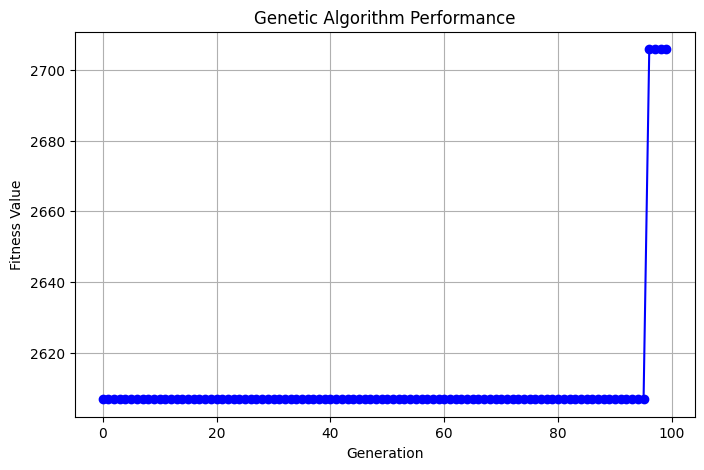

In [101]:
# Initialize lists to store fitness values and generations
fitness_values = []
generations = []

for generation in range(100): 
    offspring = list() 
    for counter in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_PROBABILITY:  
            
            p = select_parent(population)
            o = mutate(p)
        else:
            
            p1 = select_parent(population)
            p2 = select_parent(population)
            o = one_cut_xover(p1, p2)
        offspring.append(o) 

    for i in offspring:
        i.fitness = alternative_fitness(i.genotype)
    population.extend(offspring) 
    population.sort(key=lambda i: i.fitness, reverse=True) 
    population = population[:POPULATION_SIZE] 


     # Record best fitness value and generation number
    best_fitness = population[0].fitness
    fitness_values.append(best_fitness)
    generations.append(generation)
    

    print(population[0].fitness) 

# Plotting the fitness values over generations
plt.figure(figsize=(8, 5))
plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Genetic Algorithm Performance')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.show()

alternative_fitness function based

1736.8
1736.8
1736.8
1813.7333333333333
1813.7333333333333
1813.7333333333333
1813.7333333333333
1813.7333333333333
1813.7333333333333
1813.7333333333333
1887.6
1887.6
1887.6
1887.6
1887.6
1887.6
1887.6
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.0666666666666
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667
1888.2666666666667

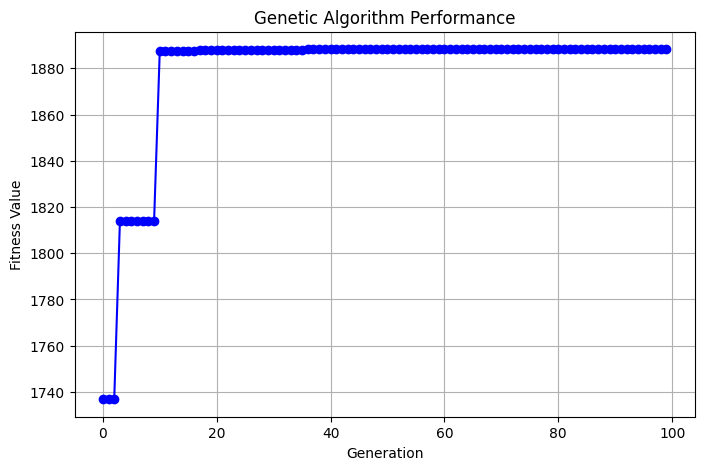

In [96]:
# Initialize lists to store fitness values and generations
fitness_values = []
generations = []

for generation in range(100): 
    offspring = list() 
    for counter in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_PROBABILITY:  
            
            p = select_parent(population)
            o = mutate(p)
        else:
            
            p1 = select_parent(population)
            p2 = select_parent(population)
            o = one_cut_xover(p1, p2)
        offspring.append(o) 

    for i in offspring:
        i.fitness = alternative_fitness(i.genotype)
    population.extend(offspring) 
    population.sort(key=lambda i: i.fitness, reverse=True) 
    population = population[:POPULATION_SIZE] 


     # Record best fitness value and generation number
    best_fitness = population[0].fitness
    fitness_values.append(best_fitness)
    generations.append(generation)
    

    print(population[0].fitness) 

# Plotting the fitness values over generations
plt.figure(figsize=(8, 5))
plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Genetic Algorithm Performance')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.show()

1736.5333333333333
1736.5333333333333
1736.5333333333333
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1813.2
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.7333333333333
1886.733333

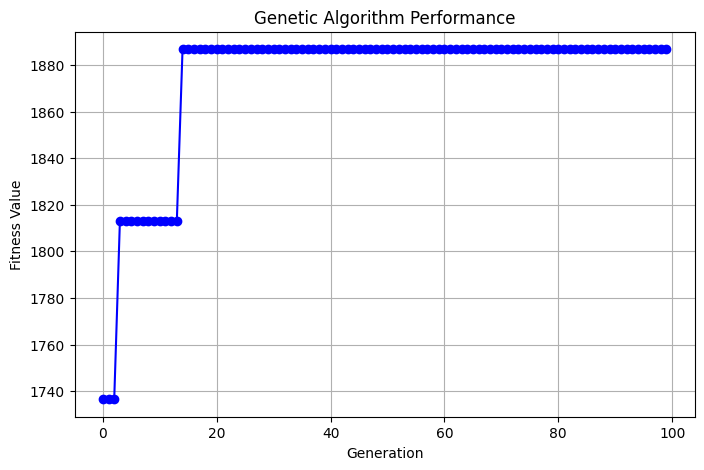

In [107]:
# Initialize lists to store fitness values and generations
fitness_values = []
generations = []

for generation in range(100): 
    offspring = list() 
    for counter in range(OFFSPRING_SIZE):
        if random.random() < MUTATION_PROBABILITY:  
            
            p = select_parent(population)
            o = mutate(p)
        else:
            
            p1 = select_parent(population)
            p2 = select_parent(population)
            o = one_cut_xover(p1, p2)
        offspring.append(o) 

    for i in offspring:
        i.fitness = alternative_fitness(i.genotype)
    population.extend(offspring) 
    population.sort(key=lambda i: i.fitness, reverse=True) 
    population = population[:POPULATION_SIZE] 


     # Record best fitness value and generation number
    best_fitness = population[0].fitness
    fitness_values.append(best_fitness)
    generations.append(generation)
    

    print(population[0].fitness) 

# Plotting the fitness values over generations
plt.figure(figsize=(8, 5))
plt.plot(generations, fitness_values, marker='o', linestyle='-', color='b')
plt.title('Genetic Algorithm Performance')
plt.xlabel('Generation')
plt.ylabel('Fitness Value')
plt.grid(True)
plt.show()